In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
joe1995_div2k_dataset_path = kagglehub.dataset_download('joe1995/div2k-dataset')

print('Data source import complete.')


In [ ]:
!pip install pytorch-wavelets

In [ ]:
import torch
import torch.nn as nn
from pytorch_wavelets import DWTForward, DWTInverse

# ------------------------ Wavelet Block ------------------------ #
class WaveletBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, mode='zero', wave='haar')
        self.conv = nn.Conv2d(9, 64, kernel_size=1)  # <--- CHANGE 12 ➔ 9
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        yl, yh = self.dwt(x)  # yl: low freq, yh: list of high freq
        yh = yh[0]  # first level
        yh = yh.reshape(yh.shape[0], -1, yh.shape[-2], yh.shape[-1])  # (B, 9, H/2, W/2)

        # Upsample high-frequency to match input
        yh_upsampled = nn.functional.interpolate(yh, size=x.shape[-2:], mode='bilinear', align_corners=False)

        features = self.relu(self.conv(yh_upsampled))
        return features




# ------------------------ Residual Block ------------------------ #
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)

# ------------------------ Generator ------------------------ #
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_features=64):
        super().__init__()
        self.wavelet = WaveletBlock()
        self.conv1 = nn.Conv2d(in_channels, num_features, 3, padding=1)
        self.res_blocks = nn.Sequential(*[ResBlock(num_features) for _ in range(8)])
        self.upconv1 = nn.ConvTranspose2d(num_features, num_features, 4, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(num_features, num_features, 4, stride=2, padding=1)
        self.conv_final = nn.Conv2d(num_features, in_channels, 3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        feat = self.conv1(x)
        wavelet_feat = self.wavelet(x)
        feat = feat + wavelet_feat
        out = self.res_blocks(feat)
        out = self.upconv1(out)
        out = self.upconv2(out)
        out = self.conv_final(out)
        return self.tanh(out)



# ------------------------ Discriminator ------------------------ #
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        def block(in_filters, out_filters, stride=1, bn=True):
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if bn:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(in_channels, 64, bn=False),
            *block(64, 64, stride=2),
            *block(64, 128),
            *block(128, 128, stride=2),
            *block(128, 256),
            *block(256, 256, stride=2),
            *block(256, 512),
            nn.Conv2d(512, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ------------------------ UNet Denoiser ------------------------ #
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNetDenoiser(nn.Module):
    def __init__(self, in_channels=3, base=64):
        super().__init__()
        self.enc1 = UNetBlock(in_channels, base)
        self.enc2 = UNetBlock(base, base*2)
        self.enc3 = UNetBlock(base*2, base*4)
        self.enc4 = UNetBlock(base*4, base*8)
        self.pool = nn.MaxPool2d(2)
        self.middle = UNetBlock(base*8, base*8)
        self.up4 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec4 = UNetBlock(base*12, base*4)
        self.up3 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec3 = UNetBlock(base*6, base*2)
        self.up2 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec2 = UNetBlock(base*3, base)
        self.up1 = nn.ConvTranspose2d(base, base, 2, stride=2)
        self.dec1 = UNetBlock(base*2, base)
        self.outc = nn.Conv2d(base, in_channels, 1)
    def forward(self, x, t=None):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        m = self.middle(self.pool(e4))
        d4 = self.up4(m)
        d4 = self.dec4(torch.cat([d4, e4], 1))
        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], 1))
        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], 1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], 1))
        out = self.outc(d1)
        return out

# ------------------------ Diffusion Generator ------------------------ #
class DiffusionGenerator(nn.Module):
    def __init__(self, in_channels=3, timesteps=100):
        super().__init__()
        self.timesteps = timesteps
        self.denoiser = UNetDenoiser(in_channels)
        self.register_buffer("betas", torch.linspace(1e-4, 0.02, timesteps))  # device-safe

    def forward(self, x):
        noise = torch.randn_like(x)
        beta = self.betas[-1].to(x.device)
        x_noisy = x + beta * noise
        for t in range(3):  # simplified diffusion steps
            x_noisy = self.denoiser(x_noisy)
        return x_noisy

# ------------------------ Combined Generator ------------------------ #
class CombinedGenerator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.diffusion = DiffusionGenerator(in_channels)
        self.gan = Generator(in_channels)

    def forward(self, x):
        x = self.diffusion(x)
        x = self.gan(x)
        return x


In [ ]:
import torch
from torchsummary import summary  # Optional, for model summary

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = CombinedGenerator().to(device)

# Dummy input - adjust size based on your expected LR image size
dummy_input = torch.randn(1, 3, 64, 64).to(device)

# Forward pass
with torch.no_grad():
    output = model(dummy_input)

# Print input and output shapes
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")

# Optional: summary of model
# summary(model, input_size=(3, 128, 128))


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random

class DIV2KDataset(Dataset):
    def __init__(self, root_dir="/kaggle/input/div2k-dataset/", train=True, scale_factor=2):
        """
        Args:
            root_dir (str): Directory with DIV2K dataset
            train (bool): If True, creates dataset from training set, otherwise from validation set
            scale_factor (int): Scale factor for super-resolution (default: 4x upscaling)
        """
        self.root_dir = root_dir
        self.train = train
        self.scale_factor = scale_factor

        # Get list of image files
        self.image_files = self._get_image_files()

        # Define transforms for LR images
        self.lr_transform = transforms.Compose([
            transforms.Resize(size=(128 // self.scale_factor, 128 // self.scale_factor),
                           interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor()
        ])

    def _get_image_files(self):
        """Get list of image files from DIV2K dataset"""
        if self.train:
            image_dir = os.path.join(self.root_dir, "DIV2K_train_HR")
        else:
            image_dir = os.path.join(self.root_dir, "DIV2K_valid_HR")

        files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        files.sort()  # Ensure consistent ordering

        if self.train:
            return files[:800]  # First 800 images for training
        return files  # All validation images

    def __len__(self):
        """Return the total number of images in the dataset"""
        return len(self.image_files)

    def __getitem__(self, idx):
        """Return a dictionary containing both LR and HR images"""
        img_name = self.image_files[idx]

        # Load HR image
        if self.train:
            img_path = os.path.join(self.root_dir, "DIV2K_train_HR", img_name)
        else:
            img_path = os.path.join(self.root_dir, "DIV2K_valid_HR", img_name)

        hr_image = Image.open(img_path).convert('RGB')

        # Random crop for training
        if self.train:
            # Random crop to fixed size for HR
            hr_cropped = transforms.RandomCrop(128 * self.scale_factor)(hr_image)
            # Create LR version
            lr_image = self.lr_transform(hr_cropped)
            # Convert HR to tensor
            hr_tensor = transforms.ToTensor()(hr_cropped)
        else:
            # For validation, use center crop
            hr_cropped = transforms.CenterCrop(128 * self.scale_factor)(hr_image)
            lr_image = self.lr_transform(hr_cropped)
            hr_tensor = transforms.ToTensor()(hr_cropped)

        return {
            'lr': lr_image,  # Low resolution image
            'hr': hr_tensor  # High resolution image
        }

# Example usage:
if __name__ == "__main__":
    # Create dataset instance
    dataset = DIV2KDataset(root_dir="/kaggle/input/div2k_train_hr/", train=True)
    print(f"Dataset size: {len(dataset)}")

    # Get a sample
    sample = dataset[0]
    print(f"LR image shape: {sample['lr'].shape}")
    print(f"HR image shape: {sample['hr'].shape}")


In [ ]:
import torchvision.models as models
import torch.nn.functional as F


class PerceptualLoss(nn.Module):
    def __init__(self, layers=[3, 8, 15, 22]):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features
        self.selected_layers = layers
        self.vgg = vgg.eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        loss = 0
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            y = layer(y)
            if i in self.selected_layers:
                loss += F.l1_loss(x, y)
        return loss


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

def train(epochs=5, batch_size=8, lr=0.0002, b1=0.5, b2=0.999):
    os.makedirs("results", exist_ok=True)
    os.makedirs("saved_models", exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Create Models and Wrap with DataParallel ---
    generator = CombinedGenerator().to(device)
    discriminator = Discriminator().to(device)

    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        generator = nn.DataParallel(generator)
        discriminator = nn.DataParallel(discriminator)
    else:
        print("Using single GPU or CPU")

    # --- Losses and Optimizers ---
    criterion_GAN = nn.BCEWithLogitsLoss()
    criterion_content = nn.L1Loss()
    criterion_diffusion = nn.MSELoss()
    criterion_perceptual = PerceptualLoss().to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

    dataset = DIV2KDataset(root_dir="/kaggle/input/div2k_train_hr/", train=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    generator_losses = []
    discriminator_losses = []
    total_losses = []

    for epoch in range(epochs):
        g_loss_epoch = 0
        d_loss_epoch = 0
        image_shown = False

        for i, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            lr_imgs = batch['lr'].to(device)
            hr_imgs = batch['hr'].to(device)

            valid = torch.ones((lr_imgs.size(0), 1, 32, 32), device=device)
            fake = torch.zeros((lr_imgs.size(0), 1, 32, 32), device=device)

            # --- Train Generator ---
            optimizer_G.zero_grad()
            gen_hr = generator(lr_imgs)
            pred_fake = discriminator(gen_hr)

            loss_GAN = criterion_GAN(pred_fake, valid)
            loss_content = criterion_content(gen_hr, hr_imgs)
            loss_diff = criterion_diffusion(gen_hr, hr_imgs)
            loss_perceptual = criterion_perceptual(gen_hr, hr_imgs)

            loss_G = loss_content + 1e-3 * loss_GAN + 1e-2 * loss_diff + 0.01 * loss_perceptual

            loss_G.backward()
            optimizer_G.step()

            # --- Train Discriminator ---
            optimizer_D.zero_grad()
            pred_real = discriminator(hr_imgs)
            loss_real = criterion_GAN(pred_real, valid)

            pred_fake = discriminator(gen_hr.detach())
            loss_fake = criterion_GAN(pred_fake, fake)


            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()
            optimizer_D.step()

            g_loss_epoch += loss_G.item()
            d_loss_epoch += loss_D.item()

        # Visualize (1st batch of each epoch)
        if not image_shown:
            num_images = min(gen_hr.size(0), 4)
            gen_images = gen_hr[:num_images].detach().cpu()
            real_images = hr_imgs[:num_images].detach().cpu()

            fig, axes = plt.subplots(2, num_images, figsize=(12, 6))
            for idx in range(num_images):
                axes[0, idx].imshow(gen_images[idx].permute(1, 2, 0).clamp(0, 1))
                axes[0, idx].set_title("Generated")
                axes[0, idx].axis("off")

                axes[1, idx].imshow(real_images[idx].permute(1, 2, 0).clamp(0, 1))
                axes[1, idx].set_title("Real")
                axes[1, idx].axis("off")

            plt.suptitle(f"Epoch {epoch+1}")
            plt.tight_layout()
            plt.show()
            image_shown = True

        # Save loss
        avg_g_loss = g_loss_epoch / len(dataloader)
        avg_d_loss = d_loss_epoch / len(dataloader)
        generator_losses.append(avg_g_loss)
        discriminator_losses.append(avg_d_loss)
        total_losses.append(avg_g_loss)

        if (epoch + 1) % 50 == 0:
            torch.save(generator.module.state_dict(), f"saved_models/generator_epoch_{epoch+1}.pth")
            torch.save(discriminator.module.state_dict(), f"saved_models/discriminator_epoch_{epoch+1}.pth")

        torch.cuda.empty_cache()

    # --- Plot Losses ---
    plt.figure(figsize=(10, 6))
    plt.plot(generator_losses, label="Generator Loss", color='blue')
    plt.plot(discriminator_losses, label="Discriminator Loss", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Losses Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("results/loss_plot.png")
    plt.show()


In [ ]:
torch.cuda.empty_cache()
train(epochs=150, batch_size=8)

In [ ]:
torch.cuda.empty_cache()

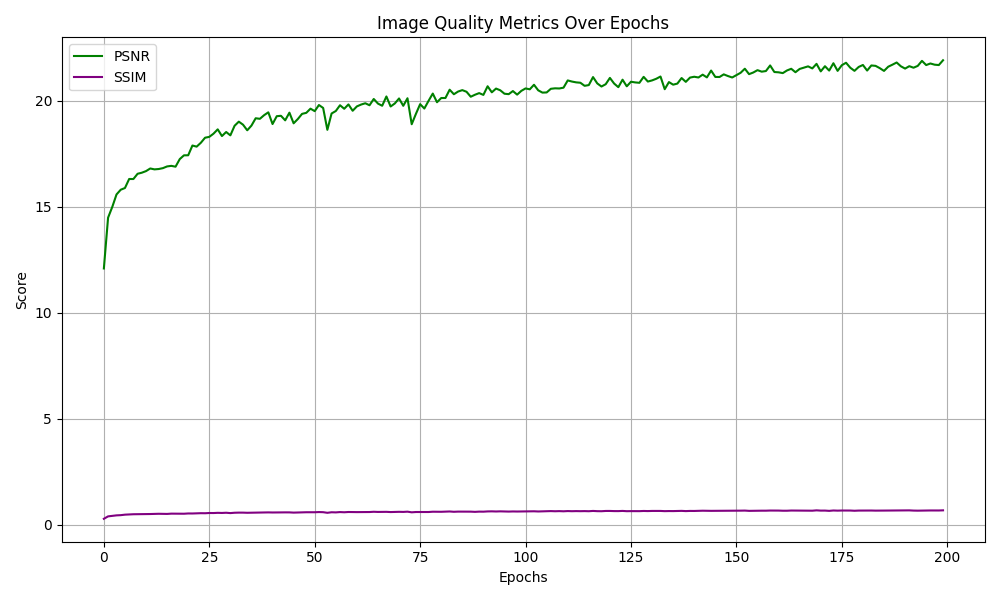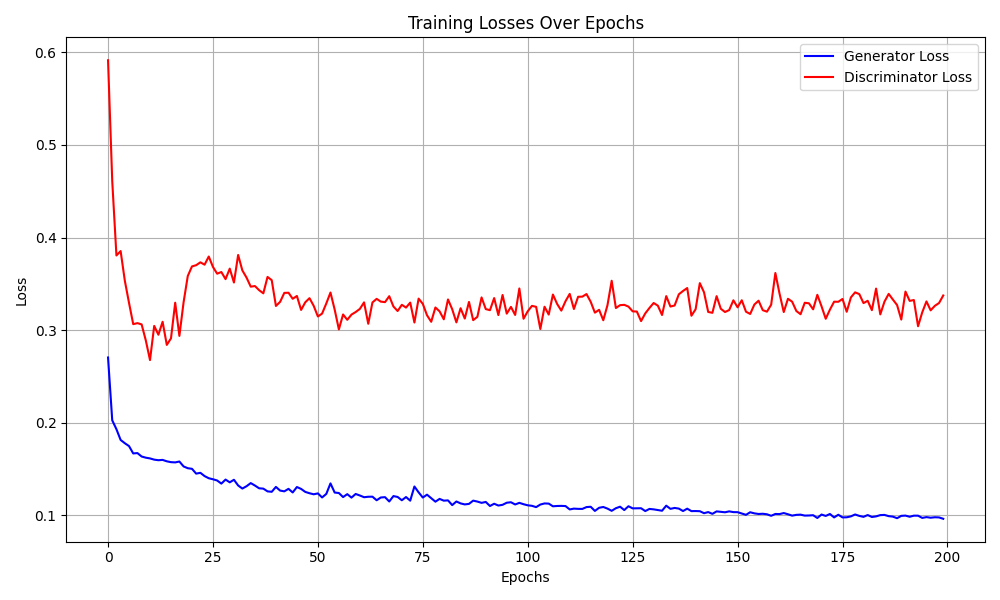